In [1]:
import torch
from torch import nn
import tqdm
from einops import rearrange
import numpy as np
import pytorch_lightning
import matplotlib.pyplot as plt

from case_studies.dc2_mdt.utils.gaussian_diffusion import (GaussianDiffusion,
                                                           get_named_beta_schedule,
                                                           ModelMeanType,
                                                           ModelVarType,
                                                           LossType)
from case_studies.dc2_mdt.utils.respace import space_timesteps, SpacedDiffusion
from case_studies.dc2_mdt.utils.resample import create_named_schedule_sampler, ScheduleSampler, SpeedSampler
from case_studies.dc2_mdt.utils.simulate_image import ImageSimulator

In [2]:
image_size = 4
add_second_source = True

In [3]:
# class SimpleMLP(nn.Module):
#     def __init__(self, layers, hidden_ch):
#         super().__init__()

#         self.network = nn.Sequential(
#             nn.Linear(1 + 1 + 16, hidden_ch),
#             nn.ReLU(),
#             *[
#                 nn.Sequential(
#                     nn.Linear(hidden_ch, hidden_ch),
#                     nn.LayerNorm(hidden_ch),
#                     nn.ReLU(),
#                 ) for _ in range(layers)
#             ],
#             nn.Linear(hidden_ch, 1)
#         )
    
#     def forward(self, x, t, image):
#         x = torch.cat([x, t.unsqueeze(1), image.flatten(start_dim=1)], dim=1)
#         return self.network(x)

In [4]:
class FourierMLP(nn.Module):
    def __init__(self, data_shape, num_layers, hidden_ch):
        super().__init__()
        self.data_shape = [data_shape]

        self.register_buffer(
            "timestep_coeff", torch.linspace(start=0.1, end=100, steps=hidden_ch)[None]
        )
        self.timestep_phase = nn.Parameter(torch.randn(hidden_ch)[None])
        self.input_embed = nn.Sequential(
            nn.Linear(int(np.prod(data_shape)), hidden_ch),
            nn.GELU(),
            nn.Linear(hidden_ch, hidden_ch)
        )
        self.timestep_embed = nn.Sequential(
            nn.Linear(2 * hidden_ch, hidden_ch),
            nn.GELU(),
            nn.Linear(hidden_ch, hidden_ch),
        )
        self.image_embed = nn.Sequential(
            nn.Linear(image_size * image_size, hidden_ch),
            nn.GELU(),
            nn.Linear(hidden_ch, hidden_ch)
        )
        self.layers = nn.Sequential(
            nn.Linear(hidden_ch * 2, hidden_ch), 
            nn.GELU(),
            *[
                nn.Sequential(nn.Linear(hidden_ch, hidden_ch), nn.GELU())
                for _ in range(num_layers)
            ],
            nn.Linear(hidden_ch, int(np.prod(data_shape))),
        )

    def forward(self, x, t, image):
        t = t.unsqueeze(-1)
        sin_embed_t = torch.sin(
            (self.timestep_coeff * t.float()) + self.timestep_phase
        )
        cos_embed_t = torch.cos(
            (self.timestep_coeff * t.float()) + self.timestep_phase
        )
        embed_t = self.timestep_embed(
            rearrange([sin_embed_t, cos_embed_t], "d b w -> b (d w)")
        )
        embed_xt = self.input_embed(x.view(x.shape[0], -1))
        embed_image = self.image_embed(image.flatten(1))
        out = self.layers(
            torch.cat([embed_xt + embed_t, embed_image], dim=-1)
        )
        return out.view(x.shape)

In [5]:
device = torch.device("cuda:7")
batch_size = 1024
val_batch_size = 2048
training_time_steps = 1000
training_iters = 5_000
val_iters = 1000
ddim_steps = 50
ddim_eta = 1.0
log_freq = 500
seed = 7272
pytorch_lightning.seed_everything(seed)

Seed set to 7272


7272

In [6]:
diffusion_config = {
    "betas": get_named_beta_schedule("linear", training_time_steps),
    "model_mean_type": ModelMeanType.EPSILON,
    "model_var_type": ModelVarType.FIXED_LARGE,
    "loss_type": LossType.MSE
}
training_diffusion = GaussianDiffusion(**diffusion_config)
sampling_diffusion = SpacedDiffusion(use_timesteps=space_timesteps(training_time_steps, f"ddim{ddim_steps}"),
                                      **diffusion_config)
# schedule_sampler = create_named_schedule_sampler("uniform", training_diffusion)
schedule_sampler = SpeedSampler(diffusion=training_diffusion,
                                lam=0.6,
                                k=5,
                                tau=700)
image_simulator = ImageSimulator(img_height=image_size,
                                 img_width=image_size,
                                 max_objects=1,
                                 min_flux=200.0,
                                 psf_stdev=1.0 if image_size > 1 else 0.1,
                                 background_intensity=100.0).to(device=device)

In [7]:
my_net = FourierMLP(data_shape=[1,], 
                    num_layers=8, 
                    hidden_ch=256).to(device=device)
# my_net = SimpleMLP(layers=8, hidden_ch=256).to(device=device)
my_optimizer = torch.optim.Adam(my_net.parameters(), lr=1e-3, amsgrad=True)

In [8]:
def encode_flux(flux: torch.Tensor):
    assert flux.min() > 0.0 and flux.max() <= 2000.0
    return (torch.log1p(flux) / 7.61) * 2 - 1

def decode_flux(flux_minus1_to_1: torch.Tensor):
    assert flux_minus1_to_1.min() >= -1.0 and flux_minus1_to_1.max() <= 1.0
    return torch.expm1((flux_minus1_to_1 + 1) / 2 * 7.61)

In [9]:
my_net.train()
loss_record = []
for i in tqdm.tqdm(list(range(training_iters))):
    catalog = image_simulator.generate(batch_size, add_second_source=add_second_source)
    t, batch_sample_weights, batch_loss_weights = schedule_sampler.sample(batch_size, device=device)
    target_fluxes = catalog["fluxes"]  # (b, 1)
    input_image = catalog["images"].unsqueeze(1)  # (b, 1, h, w)
    train_loss_args = {
        "model": my_net,
        "x_start": encode_flux(target_fluxes),
        "t": t,
        "loss_weights": batch_loss_weights
    }
    loss = training_diffusion.training_losses(**train_loss_args, 
                                              model_kwargs={"image": input_image})["loss"]
    loss = (loss * batch_sample_weights).mean()
    loss_record.append(loss.item())
    my_optimizer.zero_grad()
    loss.backward()
    my_optimizer.step()
    if (i + 1) % log_freq == 0:
        print(f"[{i + 1}/{training_iters}] loss: {loss.item():.3e}")

 10%|█         | 511/5000 [00:08<01:11, 63.17it/s]

[500/5000] loss: 9.772e-03


 20%|██        | 1008/5000 [00:16<01:02, 63.43it/s]

[1000/5000] loss: 5.469e-03


 30%|███       | 1512/5000 [00:23<00:54, 63.49it/s]

[1500/5000] loss: 3.901e-03


 40%|████      | 2009/5000 [00:31<00:46, 65.01it/s]

[2000/5000] loss: 3.472e-03


 50%|█████     | 2506/5000 [00:39<00:38, 64.14it/s]

[2500/5000] loss: 6.027e-03


 60%|██████    | 3011/5000 [00:47<00:31, 63.75it/s]

[3000/5000] loss: 2.727e-03


 70%|███████   | 3509/5000 [00:55<00:23, 62.28it/s]

[3500/5000] loss: 2.581e-03


 80%|████████  | 4006/5000 [01:03<00:15, 62.65it/s]

[4000/5000] loss: 7.038e-03


 90%|█████████ | 4508/5000 [01:10<00:06, 71.88it/s]

[4500/5000] loss: 3.392e-03


100%|██████████| 5000/5000 [01:18<00:00, 63.97it/s]

[5000/5000] loss: 2.974e-03


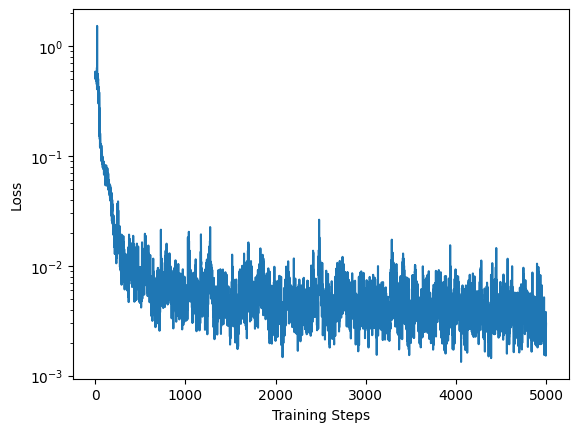

In [10]:
plt.plot(loss_record)
plt.xlabel("Training Steps")
plt.ylabel("Loss")
plt.yscale("log")
plt.show()

In [11]:
my_net.eval()
val_true_fluxes = None
val_est_fluxes = []
with torch.inference_mode():
    for i in tqdm.tqdm(list(range(val_iters))):
        val_catalog = image_simulator.generate(batch_size=val_batch_size, 
                                               seed=seed, 
                                               add_second_source=add_second_source)
        target_fluxes = val_catalog["fluxes"]  # (b, 1)
        if val_true_fluxes is None:
            val_true_fluxes = target_fluxes
        else:
            assert torch.allclose(val_true_fluxes, target_fluxes)
        input_image = val_catalog["images"].unsqueeze(1)
        diffusion_sampling_config = {
            "model": my_net,
            "shape": (val_batch_size, 1),
            "clip_denoised": True,
            "model_kwargs": {"image": input_image}
        }
        sample = sampling_diffusion.ddim_sample_loop(**diffusion_sampling_config, eta=ddim_eta)
        val_est_fluxes.append(decode_flux(sample).cpu())
val_est_fluxes = torch.stack(val_est_fluxes, dim=0)

100%|██████████| 1000/1000 [02:06<00:00,  7.91it/s]


In [12]:
val_true_fluxes = val_true_fluxes.cpu()

In [13]:
val_true_fluxes.shape

torch.Size([2048, 1])

In [14]:
val_est_fluxes.shape

torch.Size([1000, 2048, 1])

In [15]:
torch.mean((val_true_fluxes - val_est_fluxes) ** 2)

tensor(2414.6919)

In [16]:
torch.mean(torch.abs(val_true_fluxes - val_est_fluxes))

tensor(38.2169)

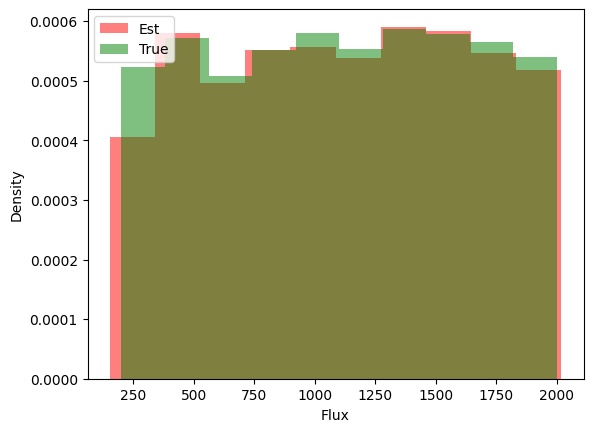

In [17]:
plt.hist(val_est_fluxes.flatten(), color="red", alpha=0.5, density=True, label="Est")
plt.hist(val_true_fluxes.flatten(), color="green", alpha=0.5, density=True, label="True")
plt.ylabel("Density")
plt.xlabel("Flux")
plt.legend()
plt.show()

In [18]:
ci_cover = torch.tensor([i / 100 for i in range(5, 100, 5)])
left_q_points = [(1.0 - c) / 2 for c in ci_cover]
right_q_points = [1.0 - lq for lq in left_q_points]
actual_ci_cover = []
for q in zip(left_q_points, right_q_points):
    q = torch.tensor(q)
    est_fluxes_q = val_est_fluxes.quantile(q=q, dim=0).permute([1, 2, 0])  # (b, 1, 2)
    above_lower_bound = val_true_fluxes[:, 0] > est_fluxes_q[:, 0, 0]
    below_upper_bound = val_true_fluxes[:, 0] < est_fluxes_q[:, 0, 1]
    actual_ci_cover.append((above_lower_bound & below_upper_bound).sum() / val_true_fluxes.shape[0])

In [19]:
actual_ci_cover = torch.cat([a.unsqueeze(0) for a in actual_ci_cover])

In [20]:
actual_ci_cover

tensor([0.0405, 0.0693, 0.1074, 0.1533, 0.1929, 0.2280, 0.2568, 0.3057, 0.3438,
        0.3838, 0.4287, 0.4688, 0.5166, 0.5625, 0.6025, 0.6523, 0.7051, 0.7607,
        0.8364])

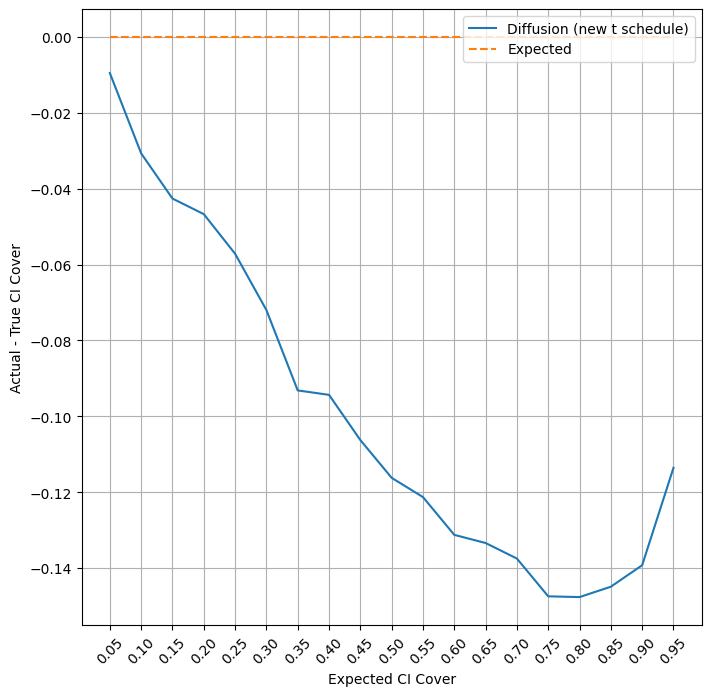

In [21]:
plt.figure(figsize=(8, 8))
a_m_c = actual_ci_cover - ci_cover
plt.plot(ci_cover, a_m_c, label="Diffusion (new t schedule)")
plt.plot(ci_cover, torch.zeros_like(ci_cover), linestyle="dashed", label="Expected")
plt.legend(loc="upper right")
plt.grid()
plt.xticks(ci_cover, rotation=45)
plt.xlabel("Expected CI Cover")
plt.ylabel("Actual - True CI Cover")
plt.show()